In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

class ECommerceTrafficPredictor:
    """
    A class for processing e-commerce clickstream data and predicting website traffic.
    Handles data preprocessing, feature engineering, model training, and forecasting.
    """
    
    def __init__(self, data_path=None, df=None):
        """
        Initialize the predictor with either a data path or DataFrame.
        
        Args:
            data_path (str, optional): Path to the CSV file
            df (DataFrame, optional): Existing DataFrame with clickstream data
        """
        if df is not None:
            self.df = df.copy()
        elif data_path:
            self.df = pd.read_csv(data_path)
        else:
            raise ValueError("Either data_path or df must be provided")
            
        self.models = {}
        self.forecasts = {}
        self.metrics = {}
        self.hourly_traffic = None
        self.holidays = None
        
    def preprocess_data(self):
        """
        Prepare data for analysis: handle missing values, convert timestamps,
        and extract time-based features.
        
        Returns:
            DataFrame: Processed DataFrame with date-time index
        """
        # Convert timestamp to datetime
        self.df['Timestamp'] = pd.to_datetime(self.df['Timestamp'])
        
        # Handle missing values for categorical columns
        self.df.fillna({
            'Outcome': 'not_purchased', 
            'ProductID': 'no_product'
        }, inplace=True)
        
        # Extract time features
        self.df['Hour'] = self.df['Timestamp'].dt.hour
        self.df['DayOfWeek'] = self.df['Timestamp'].dt.dayofweek
        self.df['Month'] = self.df['Timestamp'].dt.month
        self.df['DayName'] = self.df['Timestamp'].dt.day_name()
        self.df['IsWeekend'] = self.df['DayOfWeek'].isin([5, 6]).astype(int)
        
        # Generate US holidays
        cal = USFederalHolidayCalendar()
        self.holidays = cal.holidays(start=self.df['Timestamp'].min(), 
                                end=self.df['Timestamp'].max())
        self.df['IsHoliday'] = self.df['Timestamp'].dt.normalize().isin(self.holidays).astype(int)
        
        return self.df
    
    def aggregate_hourly_traffic(self):
        """
        Aggregate traffic by hour and event type.
        
        Returns:
            DataFrame: Hourly traffic with event types as columns
        """
        # Set timestamp as index
        df_indexed = self.df.copy()
        df_indexed.set_index('Timestamp', inplace=True)
        
        # Resample to hourly frequency and count events
        hourly = df_indexed.groupby([pd.Grouper(freq='h'), 'EventType']).size().unstack(fill_value=0)
        
        # Add total traffic column
        hourly['Total'] = hourly.sum(axis=1)
        
        # Add time features for modeling
        hourly['Hour'] = hourly.index.hour
        hourly['DayOfWeek'] = hourly.index.dayofweek
        hourly['Month'] = hourly.index.month
        hourly['IsWeekend'] = hourly['DayOfWeek'].isin([5, 6]).astype(int)
        hourly['IsHoliday'] = hourly.index.normalize().isin(self.holidays).astype(int)
        
        self.hourly_traffic = hourly
        return hourly
    
    def plot_traffic_patterns(self):
        """
        Visualize traffic patterns by hour of day and day of week.
        """
        if self.hourly_traffic is None:
            self.aggregate_hourly_traffic()
            
        # Aggregate by hour of day
        hourly_pattern = self.hourly_traffic.groupby(self.hourly_traffic.index.hour)['Total'].mean()
        
        # Aggregate by day of week
        daily_pattern = self.hourly_traffic.groupby(self.hourly_traffic.index.dayofweek)['Total'].mean()
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot hourly pattern
        sns.lineplot(x=hourly_pattern.index, y=hourly_pattern.values, ax=ax1, marker='o')
        ax1.set_title('Average Traffic by Hour of Day')
        ax1.set_xlabel('Hour')
        ax1.set_ylabel('Average Traffic Volume')
        ax1.set_xticks(range(0, 24))
        
        # Plot daily pattern
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        sns.barplot(x=days, y=daily_pattern.values, ax=ax2)
        ax2.set_title('Average Traffic by Day of Week')
        ax2.set_xlabel('Day')
        ax2.set_ylabel('Average Traffic Volume')
        ax2.set_xticklabels(days, rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    def train_random_forest_model(self, target_col='Total', test_size=0.2):
        """
        Train an XGBoost regression model for traffic prediction.
        
        Args:
            target_col (str): Target column to predict
            test_size (float): Proportion of data for testing
            
        Returns:
            tuple: (X_train, X_test, y_train, y_test)
        """
        if self.hourly_traffic is None:
            self.aggregate_hourly_traffic()

        # Prepare features
        features = ['Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'IsHoliday']
        X = self.hourly_traffic[features].copy()
        y = self.hourly_traffic[target_col].copy()

        # Add lag features (previous 24 hours and previous week)
        for i in [1, 2, 3, 6, 12, 24, 168]:  # 1hr, 2hr, 3hr, 6hr, 12hr, 24hr, 1 week
            X.loc[:, f'lag_{i}'] = y.shift(i)
        
        # Drop rows with NaN (due to lag features)
        mask = X.notna().all(axis=1)
        X = X[mask]
        y = y[mask]

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, shuffle=False
        )

        # Train model
        model = RandomForestRegressor(
            n_estimators=100,
            max_depth=5,
            random_state=42
        )
        model.fit(X_train, y_train)
        pass
        
    def train_xgboost_model(self, target_col='Total', test_size=0.2):
        """
        Train an XGBoost regression model for traffic prediction.
        
        Args:
            target_col (str): Target column to predict
            test_size (float): Proportion of data for testing
            
        Returns:
            tuple: (X_train, X_test, y_train, y_test)
        """
        if self.hourly_traffic is None:
            self.aggregate_hourly_traffic()
            
        # Prepare features
        features = ['Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'IsHoliday']
        X = self.hourly_traffic[features].copy()
        y = self.hourly_traffic[target_col].copy()
    
        # Add lag features (previous 24 hours and previous week)
        for i in [1, 2, 3, 6, 12, 24, 168]:  # 1hr, 2hr, 3hr, 6hr, 12hr, 24hr, 1 week
            X.loc[:, f'lag_{i}'] = y.shift(i)
            # X[f'lag_{i}'] = y.shift(i)
        
        # Drop rows with NaN (due to lag features)
        mask = X.notna().all(axis=1)
        X = X[mask]
        y = y[mask]
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, shuffle=False
        )
        
        # Train model
        model = XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            objective='reg:squarederror'
        )
        model.fit(X_train, y_train)
        
        # Evaluate model
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1))) * 100  # Adding 1 to avoid division by zero
        
        metrics = {
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'MAPE': mape
        }
        
        self.models['xgboost'] = model
        self.metrics['xgboost'] = metrics
        
        return X_train, X_test, y_train, y_test
    
    def train_sarima_model(self, target_col='Total'):
        """
        Train a SARIMA model for time series forecasting.
        
        Args:
            target_col (str): Target column to predict
        """
        if self.hourly_traffic is None:
            self.aggregate_hourly_traffic()
            
        # Get time series data
        ts = self.hourly_traffic[target_col]
        
        # Split data
        train_size = int(len(ts) * 0.8)
        train, test = ts[:train_size], ts[train_size:]
        
        # Fit SARIMA model
        # Order: (p,d,q) for trend, (P,D,Q,s) for seasonality
        # Using common values for hourly data
        model = SARIMAX(
            train,
            order=(2, 1, 2),          # Non-seasonal part (p,d,q)
            seasonal_order=(1, 1, 1, 24),  # Seasonal part (P,D,Q,s) - 24 for hourly data
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        fit_model = model.fit(disp=False)
        
        # Make predictions
        pred = fit_model.get_forecast(steps=len(test))
        y_pred = pred.predicted_mean
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(test, y_pred))
        mae = mean_absolute_error(test, y_pred)
        r2 = r2_score(test, y_pred)
        mape = np.mean(np.abs((test - y_pred) / (test + 1))) * 100
        
        metrics = {
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'MAPE': mape
        }
        
        self.models['sarima'] = fit_model
        self.metrics['sarima'] = metrics
        
        return fit_model, (train, test, y_pred)
    
    def train_prophet_model(self, target_col='Total'):
        """
        Train a Facebook Prophet model for forecasting.
        
        Args:
            target_col (str): Target column to predict
        """
        if self.hourly_traffic is None:
            self.aggregate_hourly_traffic()
            
        # Prepare data for Prophet
        prophet_df = self.hourly_traffic.reset_index()
        prophet_df = prophet_df.rename(columns={'Timestamp': 'ds', target_col: 'y'})
        prophet_df = prophet_df[['ds', 'y']]
        
        # Split data
        train_size = int(len(prophet_df) * 0.8)
        train = prophet_df[:train_size]
        test = prophet_df[train_size:]
        
        # Train Prophet model
        model = Prophet(
            daily_seasonality=True,
            weekly_seasonality=True,
            yearly_seasonality=True,
            changepoint_prior_scale=0.05
        )
        model.fit(train)
        
        # Make predictions for the test period
        future = model.make_future_dataframe(periods=len(test), freq='h')
        forecast = model.predict(future)
        
        # Extract predictions for the test period
        y_pred = forecast['yhat'].iloc[-len(test):].values
        y_true = test['y'].values
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1))) * 100
        
        metrics = {
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'MAPE': mape
        }
        
        self.models['prophet'] = model
        self.metrics['prophet'] = metrics
        
        return model, (train, test, forecast)
    
    def compare_models(self):
        """
        Compare performance metrics of all trained models.
        
        Returns:
            DataFrame: Metrics for all models
        """
        if not self.metrics:
            raise ValueError("No models have been trained yet")
            
        metrics_df = pd.DataFrame(self.metrics).T
        
        # Visualize comparison
        fig, ax = plt.subplots(figsize=(10, 6))
        metrics_df.plot(kind='bar', ax=ax)
        plt.title("Model Comparison: Forecast Accuracy Metrics")
        plt.ylabel("Score")
        plt.xlabel("Model")
        plt.xticks(rotation=0)
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()
        
        return metrics_df
    
    def forecast_future_traffic(self, model_name='xgboost', hours=24):
        """
        Forecast future traffic using the specified model.
        
        Args:
            model_name (str): Name of the model to use ('xgboost', 'sarima', or 'prophet')
            hours (int): Number of hours to forecast ahead
            
        Returns:
            DataFrame: Forecasted traffic
        """
        if model_name not in self.models:
            raise ValueError(f"Model {model_name} has not been trained yet")
            
        if self.hourly_traffic is None:
            self.aggregate_hourly_traffic()
            
        if model_name == 'xgboost':
            # Create future feature matrix
            last_timestamp = self.hourly_traffic.index[-1]
            future_dates = pd.date_range(start=last_timestamp + timedelta(hours=1), 
                                        periods=hours, freq='h')
            
            future_features = pd.DataFrame(index=future_dates)
            future_features['Hour'] = future_features.index.hour
            future_features['DayOfWeek'] = future_features.index.dayofweek
            future_features['Month'] = future_features.index.month
            future_features['IsWeekend'] = future_features['DayOfWeek'].isin([5, 6]).astype(int)
            
            # Check for holidays
            cal = USFederalHolidayCalendar()
            holidays = cal.holidays(start=future_features.index.min(), 
                                    end=future_features.index.max())
            future_features['IsHoliday'] = future_features.index.normalize().isin(holidays).astype(int)
            
            # Add lag features
            traffic_series = self.hourly_traffic['Total']
            for i in [1, 2, 3, 6, 12, 24, 168]:
                # For each prediction, we need to use the most recent available data
                # This requires iterative forecasting
                traffic_with_pred = traffic_series.copy()
                
                for idx, future_date in enumerate(future_dates):
                    lag_dates = {}
                    for lag in [1, 2, 3, 6, 12, 24, 168]:
                        lag_date = future_date - timedelta(hours=lag)
                        if lag_date in traffic_with_pred.index:
                            lag_dates[f'lag_{lag}'] = traffic_with_pred[lag_date]
                        else:
                            # If we're forecasting far enough, we might need predictions we just made
                            lag_idx = idx - lag
                            if lag_idx >= 0:
                                lag_dates[f'lag_{lag}'] = future_features['Predicted'][lag_idx]
                            else:
                                # Default to the last known value if we can't find it
                                lag_dates[f'lag_{lag}'] = traffic_with_pred.iloc[-1]
                    
                    # Add lag features to future_features
                    for lag, value in lag_dates.items():
                        future_features.loc[future_date, lag] = value
                    
                    # Make prediction for this hour
                    X_pred = future_features.loc[future_date:future_date]
                    pred = self.models['xgboost'].predict(X_pred)[0]
                    future_features.loc[future_date, 'Predicted'] = pred
                    
                    # Add prediction to our series for next iteration
                    traffic_with_pred[future_date] = pred
            
            forecast = future_features[['Predicted']].rename(columns={'Predicted': 'Traffic'})
            
        elif model_name == 'sarima':
            # For SARIMA, we can directly forecast future values
            forecast_obj = self.models['sarima'].get_forecast(steps=hours)
            predictions = forecast_obj.predicted_mean
            confidence_intervals = forecast_obj.conf_int()
            
            forecast = pd.DataFrame({
                'Traffic': predictions,
                'Lower_CI': confidence_intervals.iloc[:, 0],
                'Upper_CI': confidence_intervals.iloc[:, 1]
            })
            
        elif model_name == 'prophet':
            # For Prophet, create future dataframe and predict
            model = self.models['prophet']
            future = model.make_future_dataframe(periods=hours, freq='h')
            prophet_forecast = model.predict(future)
            
            # Extract just the future period
            future_forecast = prophet_forecast.iloc[-hours:]
            
            forecast = pd.DataFrame({
                'Traffic': future_forecast['yhat'],
                'Lower_CI': future_forecast['yhat_lower'],
                'Upper_CI': future_forecast['yhat_upper']
            }, index=future_forecast['ds'])
        
        self.forecasts[model_name] = forecast
        return forecast
    
    def plot_forecasts(self, hours_to_show_historical=48):
        """
        Plot all forecasts together with historical data.
        
        Args:
            hours_to_show_historical (int): Number of historical hours to include in plot
        """
        if not self.forecasts:
            raise ValueError("No forecasts have been generated yet")
            
        # Get historical data
        historical = self.hourly_traffic['Total']
        historical_to_show = historical[-hours_to_show_historical:]
        
        # Create plot
        plt.figure(figsize=(14, 8))
        
        # Plot historical data
        plt.plot(historical_to_show.index, historical_to_show, 'k-', label='Historical Traffic')
        
        # Plot each forecast
        colors = ['blue', 'red', 'green']
        for i, (model_name, forecast) in enumerate(self.forecasts.items()):
            plt.plot(forecast.index, forecast['Traffic'], 
                     color=colors[i % len(colors)], 
                     label=f'{model_name.upper()} Forecast')
            
            # Plot confidence intervals if available
            if 'Lower_CI' in forecast.columns and 'Upper_CI' in forecast.columns:
                plt.fill_between(forecast.index, 
                                forecast['Lower_CI'], 
                                forecast['Upper_CI'],
                                color=colors[i % len(colors)], 
                                alpha=0.2)
        
        plt.title('Website Traffic Forecast')
        plt.xlabel('Date')
        plt.ylabel('Traffic Volume')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    def identify_peak_times(self, forecast, threshold_percentile=90):
        """
        Identify peak traffic times in the forecast.
        
        Args:
            forecast (DataFrame): Forecasted traffic
            threshold_percentile (int): Percentile threshold for identifying peaks
            
        Returns:
            DataFrame: Peak traffic times
        """
        # Calculate threshold
        threshold = np.percentile(forecast['Traffic'], threshold_percentile)
        
        # Identify peaks
        peaks = forecast[forecast['Traffic'] >= threshold].copy()
        peaks['IsPeak'] = True
        
        return peaks


Aggregated 4931 hours of traffic data


/var/folders/sb/_wglw_tj2s33qkd3sqbydk480000gn/T/ipykernel_51595/4292807435.py:127: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(days, rotation=45)


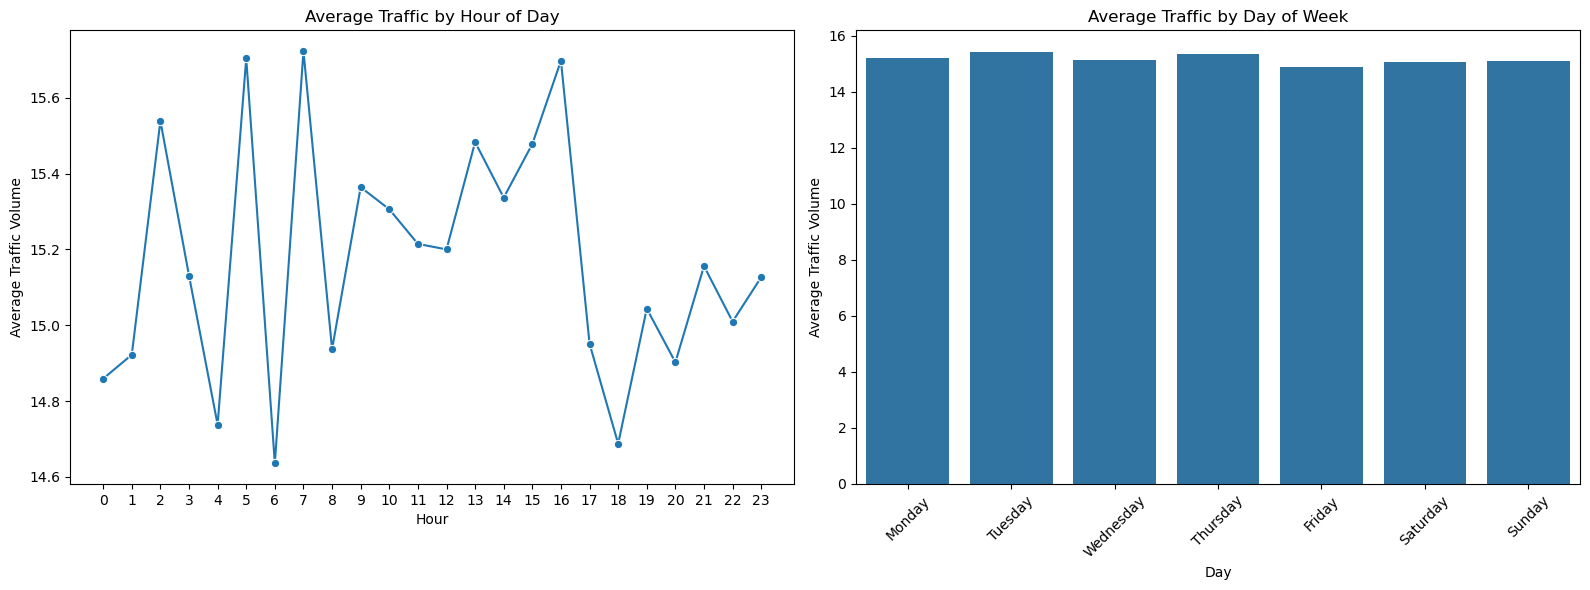

Training XGBoost model...
Training SARIMA model...


15:35:58 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet model...


15:35:58 - cmdstanpy - INFO - Chain [1] done processing


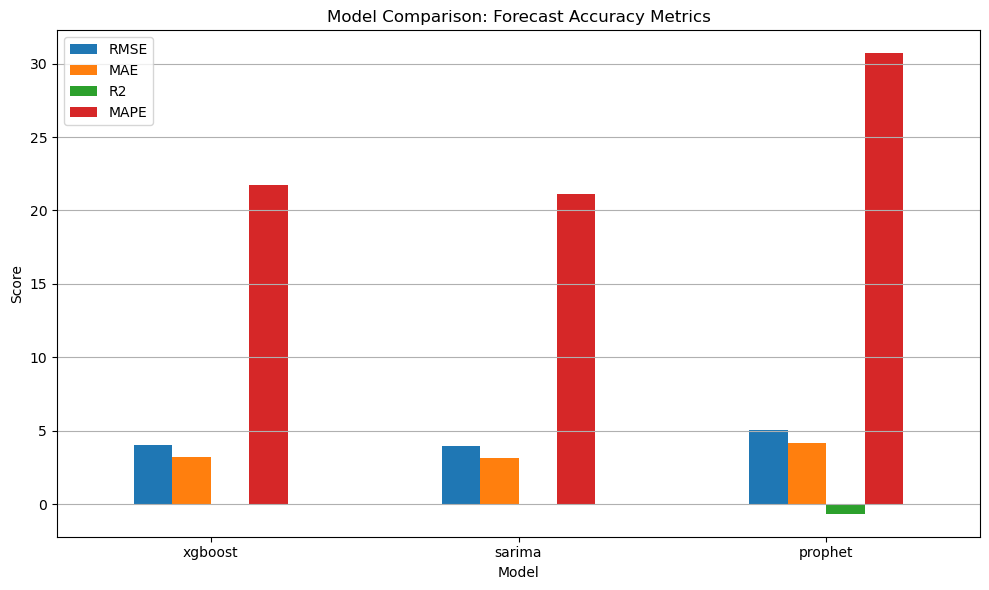


Model Comparison:
             RMSE       MAE        R2       MAPE
xgboost  4.012008  3.207642 -0.043278  21.714513
sarima   3.932539  3.147375 -0.008479  21.154487
prophet  5.025984  4.146677 -0.647262  30.697336

Generating forecasts...
Best model based on RMSE: sarima


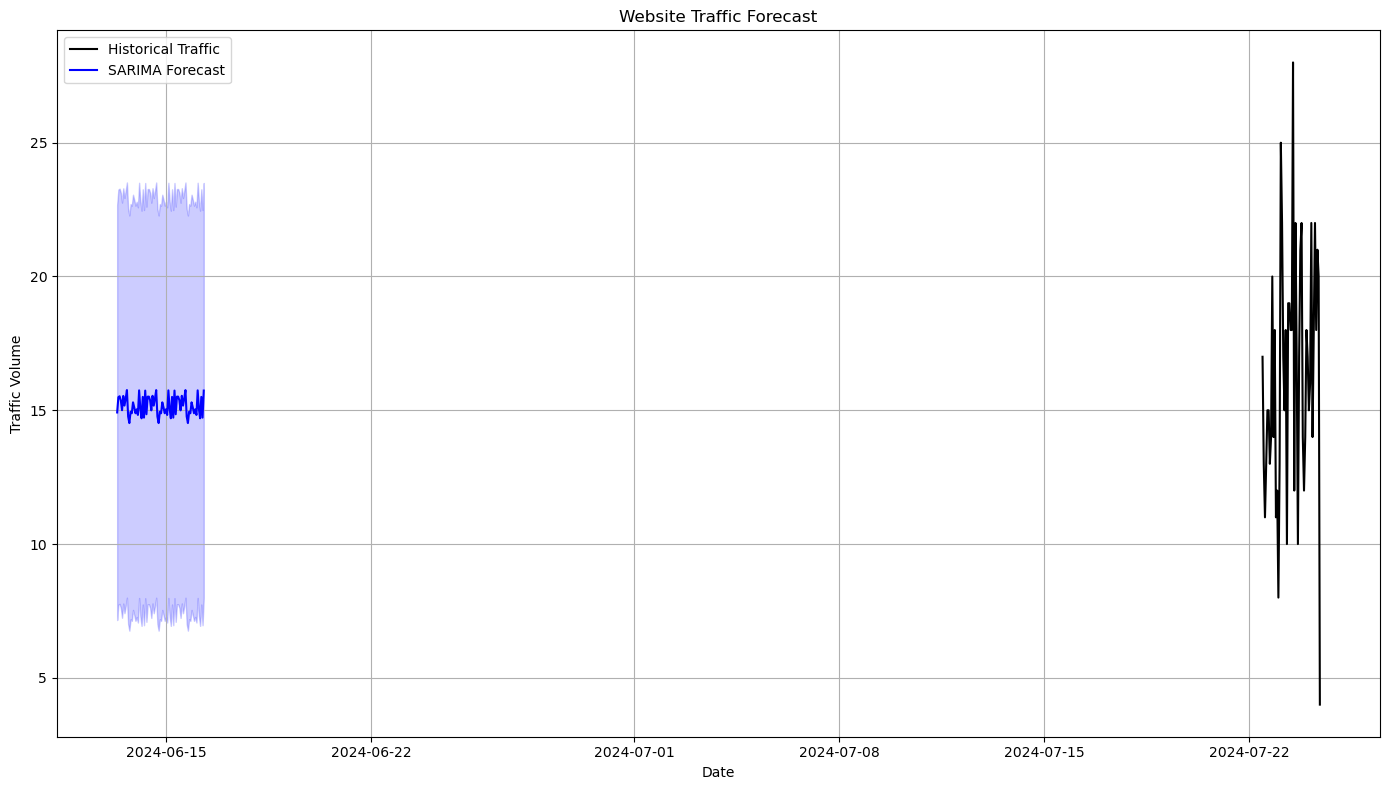


Predicted Peak Traffic Times:
                       Traffic  Lower_CI   Upper_CI  IsPeak
2024-06-13 16:00:00  15.755924  7.996905  23.514942    True
2024-06-14 02:00:00  15.744606  7.985652  23.503560    True
2024-06-14 16:00:00  15.754189  7.995107  23.513271    True
2024-06-15 02:00:00  15.744619  7.985603  23.503636    True
2024-06-15 07:00:00  15.737115  7.978140  23.496090    True
2024-06-15 16:00:00  15.754395  7.995238  23.513552    True
2024-06-16 02:00:00  15.744826  7.985733  23.503918    True
2024-06-16 07:00:00  15.737321  7.978271  23.496372    True


In [6]:
if __name__ == "__main__":
    # Initialize with data
    predictor = ECommerceTrafficPredictor('./ecommerce_clickstream_transactions.csv')
    
    # Preprocess data
    predictor.preprocess_data()
    
    # Aggregate to hourly traffic
    hourly_data = predictor.aggregate_hourly_traffic()
    print(f"Aggregated {len(hourly_data)} hours of traffic data")
    
    # Visualize traffic patterns
    predictor.plot_traffic_patterns()
    
    # Train models
    print("Training XGBoost model...")
    predictor.train_xgboost_model()
    
    print("Training SARIMA model...")
    predictor.train_sarima_model()
    
    print("Training Prophet model...")
    predictor.train_prophet_model()
    
    # Compare models
    metrics = predictor.compare_models()
    print("\nModel Comparison:")
    print(metrics)
    
    # Generate forecasts
    print("\nGenerating forecasts...")
    best_model = metrics['RMSE'].idxmin()  # Choose model with lowest RMSE
    print(f"Best model based on RMSE: {best_model}")
    
    # Forecast next 72 hours (3 days)
    forecast = predictor.forecast_future_traffic(model_name=best_model, hours=72)
    
    # Plot forecasts
    predictor.plot_forecasts()
    
    # Identify peak times
    peaks = predictor.identify_peak_times(forecast)
    print("\nPredicted Peak Traffic Times:")
    print(peaks)